In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import networkx as nx
from torch_geometric.utils import from_networkx

import sys
sys.path.insert(0, "..")
from shared.GNNModel import GNNModel

def run_training():
    # 1. 加载数据
    loaded_data = torch.load('../training_data.pt')
    X_tensor_loaded = loaded_data['X_tensor']  # shape (2907, 10, 1536)
    search_terms_tensor_loaded = loaded_data['search_terms_tensor']  # shape (2907, 1536)
    labels_tensor_loaded = loaded_data['labels_tensor']  # shape (2907,)

    print("Loaded data:")
    print("X_tensor_loaded shape:", X_tensor_loaded.shape)
    print("search_terms_tensor_loaded shape:", search_terms_tensor_loaded.shape)
    print("labels_tensor_loaded shape:", labels_tensor_loaded.shape)

    # 2. 从GraphML文件中加载图
    gml_file = '../assets/pmfg_graph.graphml'
    G = nx.read_graphml(gml_file)
    print("Graph loaded.")
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

    # 将 NetworkX 图转换为 PyTorch Geometric 的数据结构
    data = from_networkx(G)
    print(data)


    num_nodes = max(labels_tensor_loaded)+1
    if 'x' not in data:
        # 初始化为随机特征或根据需要初始化
        data.x = torch.rand(num_nodes, 1536)

    edge_index = data.edge_index
    x = data.x

    # 3. 定义模型、优化器、损失函数
    # 根据数据，embedding_size=1536
    time_series_length = X_tensor_loaded.size(1)  # 应为10
    model = GNNModel(num_nodes=num_nodes, time_series_length=time_series_length, embedding_size=1536)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 4. 使用DataLoader进行批训练
    dataset = TensorDataset(search_terms_tensor_loaded, X_tensor_loaded, labels_tensor_loaded)
    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 开始训练
    num_epochs = 20
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for search_batch, time_series_batch, label_batch in dataloader:
            optimizer.zero_grad()
            # 前向传播
            output = model(search_batch, time_series_batch, edge_index, x)
            # 计算损失
            loss = criterion(output, label_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")
    # 假设你的模型为 model
    torch.save(model.state_dict(), "model.pth")
    print("Model saved.")


# 运行训练
run_training()


Graph loaded.
Number of nodes: 287
Number of edges: 813
Data(edge_index=[2, 1626], weight=[1626], num_nodes=287)


NameError: name 'labels_tensor_loaded' is not defined

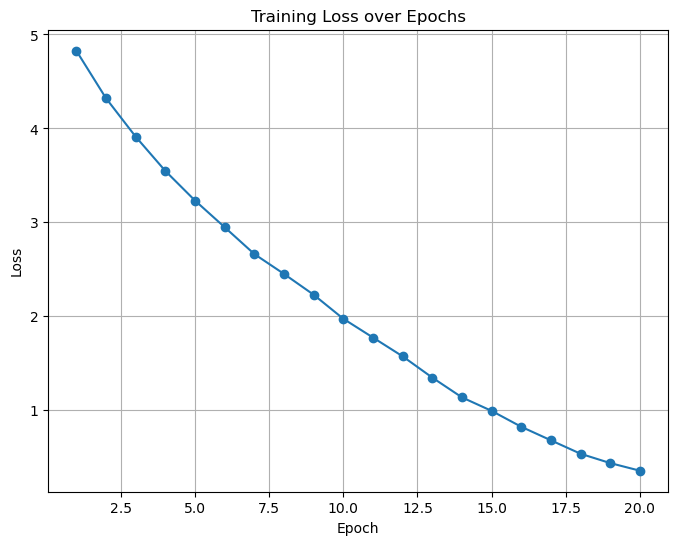

In [14]:
import matplotlib.pyplot as plt
import re

# 给定输出字符串
log_str = """Epoch [1/20], Loss: 4.8272
Epoch [2/20], Loss: 4.3214
Epoch [3/20], Loss: 3.9122
Epoch [4/20], Loss: 3.5476
Epoch [5/20], Loss: 3.2325
Epoch [6/20], Loss: 2.9484
Epoch [7/20], Loss: 2.6630
Epoch [8/20], Loss: 2.4514
Epoch [9/20], Loss: 2.2298
Epoch [10/20], Loss: 1.9740
Epoch [11/20], Loss: 1.7740
Epoch [12/20], Loss: 1.5740
Epoch [13/20], Loss: 1.3475
Epoch [14/20], Loss: 1.1371
Epoch [15/20], Loss: 0.9933
Epoch [16/20], Loss: 0.8240
Epoch [17/20], Loss: 0.6799
Epoch [18/20], Loss: 0.5368
Epoch [19/20], Loss: 0.4375
Epoch [20/20], Loss: 0.3565
"""

# 使用正则表达式匹配epoch和loss值
lines = log_str.strip().split('\n')
epochs = []
losses = []
pattern = r'Epoch \[(\d+)/\d+\], Loss: ([\d\.]+)'

for line in lines:
    match = re.search(pattern, line)
    if match:
        epoch = int(match.group(1))
        loss = float(match.group(2))
        epochs.append(epoch)
        losses.append(loss)

# 绘制Loss曲线
plt.figure(figsize=(8,6))
plt.plot(epochs, losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [7]:
num_nodes = 298
time_series_length = 10
model = GNNModel(num_nodes=num_nodes, time_series_length=time_series_length, embedding_size=1536)
model.load_state_dict(torch.load("model.pth"))
model.eval()  # 设置为推理模式

GNNModel(
  (lstm): LSTM(1536, 256, num_layers=2, batch_first=True)
  (search_term_mlp): Sequential(
    (0): Linear(in_features=1536, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (gnn1): GCNConv(1536, 256)
  (gnn2): GCNConv(256, 128)
  (integration_mlp): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=298, bias=True)
  )
)